### Data Preprocessing

In [308]:
import csv
import cv2
import math
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf 
print(tf.__version__)
from keras import Model
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape, Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import epsilon
from tensorflow.keras import backend as K
import pandas as pd

2.8.0


#### Data Initialization

In [309]:
#hyper parameters
# 0.35, 0.5
ALPHA = 0.5
IMAGE_SIZE = 96
EPOCHS = 5
BATCH_SIZE = 3
Training_data = "./oilannotation/train_data_n.csv"
path_ = "./oilspill"
CLASSES = 2

#### image resizing, coordinates resizing, 1-to-3 channel conversion

In [310]:
class DataGenerator(Sequence):

    def __init__(self, csv_file):
        self.paths = []
        with open(csv_file, "r") as file:
            self.coords = np.zeros((sum(1 for line in file), 4 + CLASSES))
            file.seek(0)
            reader = csv.reader(file, delimiter=",")
            header = next(reader)
            for index, row in enumerate(reader):
                for i, r in enumerate(row[1:10]):
                    row[i+1] = r
                      
                _,xml_path,im,image_width,image_height, x0, x1, y0, y1,classtype,class_id = row
                #print(xml_path,im,image_width,image_height, x0, x1, y0, y1,classtype,class_id)
                try:
                    x0 = int(x0)
                    y0 = int(y0)
                    x1 = int(x1)
                    y1 = int(y1)
                    image_height = int(image_height)
                    image_width = int(image_width)
                    image_name = path_+"/"+im
              
                    self.coords[index, 0] = x0 * IMAGE_SIZE / image_width
                    self.coords[index, 1] = y0 * IMAGE_SIZE / image_height
                    self.coords[index, 2] = (x1 - x0) * IMAGE_SIZE / image_width
                    self.coords[index, 3] = (y1 - y0) * IMAGE_SIZE / image_height 
                    self.coords[index, min(4 + int(class_id), self.coords.shape[1]-1)] = 1
                    
                    self.paths.append(image_name)
                except ValueError:
                    pass
            

    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)
    

    def __getitem__(self, idx):
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            img = Image.open(f)
            img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
            img = img.convert('RGB')

            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
            img.close()

        return batch_images, [batch_coords[...,:4], batch_coords[...,4:]]

#### Model Creation - MobileNetV2 algorithm

In [311]:
def create_model(trainable=False):
    model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet")
    # to freeze layers
    for layer in model.layers:
        layer.trainable = trainable

    out = model.layers[-1].output

    x = Conv2D(4, kernel_size=3)(out)
    x = Reshape((4,), name="coords")(x)

    y = GlobalAveragePooling2D()(out)
    y = Dense(CLASSES, name="classes", activation="softmax")(y)

    return Model(inputs=model.input, outputs=[x,y])

#### Loss Functions

In [312]:
def log_mse(y_true, y_pred):
    return tf.math.reduce_mean(tf.math.log1p(tf.math.squared_difference(y_pred, y_true)), axis=-1)

def focal_loss_binary(gamma = 2.0,alpha = 0.25):
    """Binary cross-entropy focal loss
    """
    def loss(y_true, y_pred):
        gamma = 2.0
        alpha = 0.25

        pt_1 = tf.where(tf.equal(y_true, 1),
                        y_pred,
                        tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0),
                        y_pred,
                        tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN and Inf
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        weight = alpha * K.pow(1. - pt_1, gamma)
        fl1 = -K.sum(weight * K.log(pt_1))
        weight = (1 - alpha) * K.pow(pt_0, gamma)
        fl0 = -K.sum(weight * K.log(1. - pt_0))
        loss = fl1 + fl0
        return loss
    return loss


In [313]:
def jaccard_coef(y_true, y_pred):
    y_true_f = tf.where(tf.equal(y_true, 1),
                        y_pred,
                        tf.ones_like(y_pred))
#     print(y_true_f)
    y_pred_f = tf.where(tf.equal(y_true, 0),
                        y_pred,
                        tf.zeros_like(y_pred))
#     print(y_pred_f)
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)
    return 1 - score

#### Feeding csv to data generation - model - model summary

In [314]:
model=create_model()

In [315]:
traingen = DataGenerator(Training_data)

In [316]:
optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss={"coords" : log_mse, "classes" : focal_loss_binary()}, loss_weights={"coords" : 1, "classes" : 1}, optimizer=optimizer, metrics=['accuracy',jaccard_coef])

In [317]:
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 16)   432         ['input_20[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 16)   64          ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 16)   0           ['bn_Conv1[0][0]']               
                                                                                           

                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 12, 12, 96)  384         ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 12, 12, 96)   0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 12, 12, 16)   1536        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 12, 12, 16)  64          ['block_3_project[0][0]']        
 lization)                                                                                        
          

                                                                                                  
 block_7_expand_relu (ReLU)     (None, 6, 6, 192)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 6, 6, 192)   1728        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 6, 6, 192)   768         ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_depthwise_relu (ReLU)  (None, 6, 6, 192)    0           ['block_7_depthwise_BN[0][0]']   
          

 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 6, 6, 288)    13824       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 6, 6, 288)   1152        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 6, 6, 288)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_depthwise (DepthwiseC  (None, 6, 6, 288)   2592        ['block_11_expand_relu[0][0]']   
 onv2D)   

 block_14_depthwise_relu (ReLU)  (None, 3, 3, 480)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 3, 3, 80)     38400       ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 3, 3, 80)    320         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 3, 3, 80)     0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
                                                                                                  
 block_15_

In [318]:
result = model.fit_generator(traingen,epochs=EPOCHS)

C:\Users\Sam\AppData\Local\Temp\ipykernel_6816\2205678644.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  result = model.fit_generator(traingen,epochs=EPOCHS)


Epoch 1/5
23/29 [======================>.......] - ETA: 0s - loss: 6.9231 - coords_loss: 5.5880 - classes_loss: 1.3350 - coords_accuracy: 0.3485 - coords_jaccard_coef: 0.8829 - classes_accuracy: 0.5303 - classes_jaccard_coef: 0.5313

C:\Users\Sam\anaconda3\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


29/29 [==============================] - 7s 44ms/step - loss: 6.6332 - coords_loss: 5.5217 - classes_loss: 1.1115 - coords_accuracy: 0.2857 - coords_jaccard_coef: 0.8912 - classes_accuracy: 0.5833 - classes_jaccard_coef: 0.5595
Epoch 2/5
29/29 [==============================] - 1s 45ms/step - loss: 5.0934 - coords_loss: 4.9298 - classes_loss: 0.1636 - coords_accuracy: 0.2976 - coords_jaccard_coef: 0.8912 - classes_accuracy: 0.8929 - classes_jaccard_coef: 0.7044
Epoch 3/5
29/29 [==============================] - 1s 45ms/step - loss: 4.7811 - coords_loss: 4.7109 - classes_loss: 0.0702 - coords_accuracy: 0.5000 - coords_jaccard_coef: 0.8912 - classes_accuracy: 0.9762 - classes_jaccard_coef: 0.7337
Epoch 4/5
29/29 [==============================] - 1s 45ms/step - loss: 4.5402 - coords_loss: 4.5088 - classes_loss: 0.0314 - coords_accuracy: 0.4048 - coords_jaccard_coef: 0.8912 - classes_accuracy: 1.0000 - classes_jaccard_coef: 0.7507
Epoch 5/5
29/29 [==============================] - 1s 43ms

#### Save the model weights

In [319]:
model.save_weights("model_training_0.5_1.h5")

## Training prediction figures

In [320]:
unscaled = cv2.imread("./oilspill/oil_spill_1.jpg")
image_height, image_width, _= unscaled.shape

image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

region, class_id = model.predict(x=np.array([feat_scaled]))
print(region,class_id)
region =  region[0]

print(region)
x0 = int(region[0] * image_width / IMAGE_SIZE)
y0 = int(region[1]  * image_height / IMAGE_SIZE)
x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE) 
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE) 

class_id = np.argmax(class_id, axis=1)
print("x0:",x0)
print("y0:",y0)
print("x1:",x1)
print("y1:",y1)
print("class",class_id)
print(image_height,image_width) 

[[11.093274 16.45755  79.70193  83.73629 ]] [[0.16500863 0.8349914 ]]
[11.093274 16.45755  79.70193  83.73629 ]
x0: 69
y0: 81
x1: 567
y1: 496
class [1]
476 600


In [321]:
df = pd.read_csv(Training_data)

In [322]:
df_1 = df[df['image']=="oil_spill_1.jpg"]
x0_ = int(df_1['xmins'])
x1_ = int(df_1['xmaxs'])
y0_ = int(df_1['ymins'])
y1_ = int(df_1['ymaxs'])


In [323]:
# COORDINATES OF THE INTERSECTION BOX
a1 = max(x0, x0_)
b1 = max(y0, y0_)
a2 = min(x1, x1_)
b2 = min(y1, y1_)
       
width = (a1 - a2)
height = (b1 - b2)
# handle case where there is NO overlap
if (width<0) or (height<0):
    iou = 0
area_overlap = width * height

area_a = (x1-x0)*(y1-y0)
area_b = (x1_-x0_)*(y1_-y0_)

area_combined = area_a+ area_b - area_overlap

iou = round(area_overlap/(area_combined+1e-5),4)
print(iou)

0.7111


In [324]:
img = cv2.rectangle(unscaled, (x0, y0), (x1, y1), (255, 0, 0), 2)
img = cv2.rectangle(unscaled, (x0_, y0_), (x1_, y1_), (0,255, 0), 2)

img = cv2.putText(unscaled, "IOU: {}".format(iou), (x0+3, y0), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2, cv2.LINE_AA)
img = cv2.putText(unscaled, "GROUND TRUTH", (x0_ -1, y0_ -1), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2, cv2.LINE_AA)

cv2.imshow("image",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [325]:
cv2.imwrite("output.jpg",img)

True

In [326]:
import matplotlib.pyplot as plt

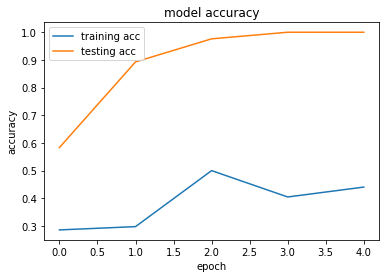

In [327]:
plt.figure(1)  
plt.plot(result.history['coords_accuracy'])  
plt.plot(result.history['classes_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['training acc', 'testing acc'], loc='upper left')  
plt.show()

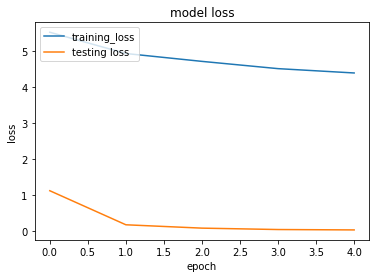

In [328]:
plt.plot(result.history['coords_loss'])  
plt.plot(result.history['classes_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['training_loss', 'testing loss'], loc='upper left')  
plt.show()

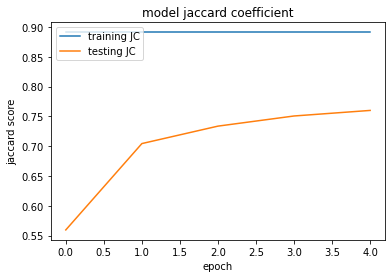

In [329]:
plt.figure(1)  
plt.plot(result.history['coords_jaccard_coef'])  
plt.plot(result.history['classes_jaccard_coef'])  
plt.title('model jaccard coefficient')  
plt.ylabel('jaccard score')  
plt.xlabel('epoch')  
plt.legend(['training JC', 'testing JC'], loc='upper left')  
plt.show()